### - Sobhan Moradian Daghigh
#### - 5/29/2022
#### - ANN - HW06

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import urllib

import tensorflow as tf, keras
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, LSTM, Dropout

import warnings
warnings.filterwarnings("ignore")

import itertools

%load_ext tensorboard

In [2]:
print(tf.__version__)

2.8.0


In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
tb_callback = keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/logs', histogram_freq=1)

In [12]:
class EarlyStoppingCallback(keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = np.inf
    self.wait = 0
  
  def on_epoch_end(self, epoch, logs=None):
    current_loss = logs.get('loss')
    if np.less(current_loss, self.best):
      self.best = current_loss
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if np.greater_equal(self.wait, self.patience):
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

In [13]:
es_callback = EarlyStoppingCallback(patience=3)

# Load Data

In [14]:
def load_data(base_url):
  datas = []
  file_names = []

  with urllib.request.urlopen(base_url + 'names.txt') as names:
    idx = 0
    for name in names.readlines():
      name = name.decode("utf-8").split('\n')[0]
      data = pd.read_csv(base_url + name, delimiter=',', encoding='utf-16-le')
      if not data.empty:
        datas.append(data)
        file_names.append(name)
        print('   |_ {}- {} loaded.'.format(idx, name))
        idx += 1

  return datas, file_names

In [15]:
base_url = 'https://raw.githubusercontent.com/nahbos/AUT-Neural-Networks/main/HW06/dataset/'
datas, names = load_data(base_url)

   |_ 0- IRX6XAFF0005.csv loaded.
   |_ 1- IRX6XALS0002.csv loaded.
   |_ 2- IRX6XS300003.csv loaded.
   |_ 3- IRX6XSLC0000.csv loaded.
   |_ 4- IRX6XSNT0009.csv loaded.
   |_ 5- IRX6XTAL0001.csv loaded.
   |_ 6- IRX6XTPI0009.csv loaded.
   |_ 7- IRX6XTPI0009[2022-05-23-10-18-57].csv loaded.
   |_ 8- IRX6XTPI0025.csv loaded.
   |_ 9- IRX6XWAI0001.csv loaded.
   |_ 10- IRXYXTPI0009.csv loaded.
   |_ 11- IRXYXTPI0025.csv loaded.
   |_ 12- IRXZXCMI0000.csv loaded.
   |_ 13- IRXZXENG0009.csv loaded.
   |_ 14- IRXZXOBM0003.csv loaded.
   |_ 15- IRXZXOCI0008.csv loaded.
   |_ 16- IRXZXTRI0006.csv loaded.
   |_ 17- IRXZXWDI0007.csv loaded.


In [16]:
rand = 13 #rand = np.random.randint(len(datas))  ## TODO
demo = datas[rand]
demo.head()

,<TICKER>,<DTYYYYMMDD>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPENINT>,<OPENINT>.1,<OPENINT>.2,<COl12>,<COl13>,<LAST>
0,فني_مهندسي6,20190908,105.0,105.0,105.0,105.0,136736,1.190834e+09,965,8709000.0,IFB EngineeringInd,شاخص_فني_مهندسي,105.0
1,فني_مهندسي6,20190911,110.2,110.2,110.2,110.2,183791,1.680585e+09,1272,9144000.0,IFB EngineeringInd,شاخص_فني_مهندسي,110.2
2,فني_مهندسي6,20190914,115.7,115.7,115.7,115.7,330061,3.168916e+09,2259,9601000.0,IFB EngineeringInd,شاخص_فني_مهندسي,115.7
3,فني_مهندسي6,20190915,121.5,121.5,121.5,121.5,356956,3.598473e+09,2444,10081000.0,IFB EngineeringInd,شاخص_فني_مهندسي,121.5
4,فني_مهندسي6,20190916,127.6,127.6,127.6,127.6,341246,3.612089e+09,2320,10585000.0,IFB EngineeringInd,شاخص_فني_مهندسي,127.6


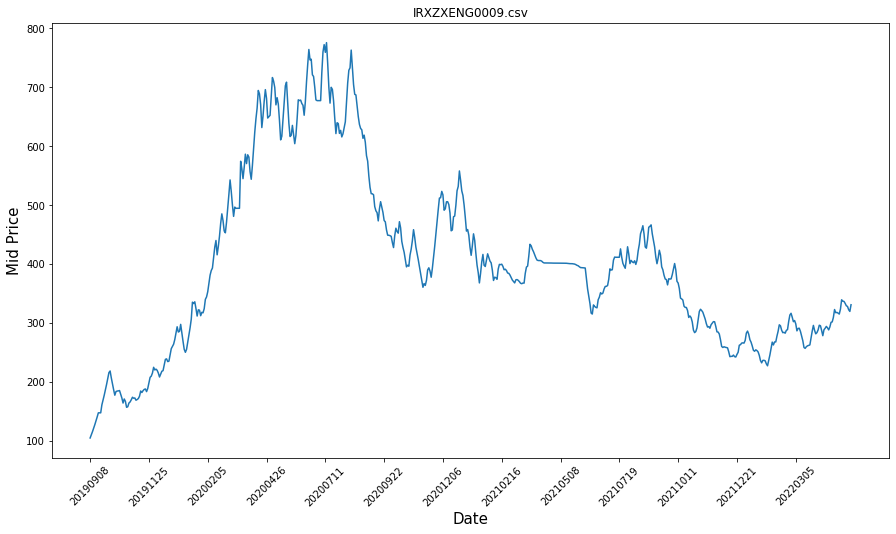

In [17]:
plt.figure(figsize = (15, 8))
plt.plot(range(demo.shape[0]), (demo['<LOW>'] + demo['<HIGH>']) / 2.0)
plt.xticks(range(0, demo.shape[0], 50), demo['<DTYYYYMMDD>'].loc[::50], rotation=45)
plt.title(names[rand])
plt.xlabel('Date', fontsize=15)
plt.ylabel('Mid Price', fontsize=15)
plt.show()

In [18]:
demo.columns

Index(['<TICKER>', '<DTYYYYMMDD>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>',
       '<VOL>', '<OPENINT>', '<OPENINT>.1', '<OPENINT>.2', '<COl12>',
       '<COl13>', '<LAST>'],
      dtype='object')

## Data Normalization

In [19]:
attrs = [2, 3, 4, 5, 6, 7, 8, 9, 12]
headers = demo.columns[attrs]
training_set = demo.iloc[:, demo.columns.isin(headers)]
scaler = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = pd.DataFrame(scaler.fit_transform(training_set), columns=headers)
training_set_scaled.head()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<OPENINT>,<OPENINT>.1,<OPENINT>.2,<LAST>
0,0.136559,0.000000,0.000000,0.000000,0.004355,0.000942,0.009155,0.000000,0.000000
1,0.143322,0.007661,0.007790,0.007790,0.005854,0.001330,0.012067,0.007816,0.007790
2,0.150475,0.015763,0.016030,0.016030,0.010512,0.002508,0.021430,0.016027,0.016030
3,0.158018,0.024308,0.024719,0.024719,0.011369,0.002848,0.023185,0.024651,0.024719
4,0.165951,0.033294,0.033858,0.033858,0.010868,0.002859,0.022009,0.033707,0.033858


In [20]:
training_set_scaled.shape

(648, 9)

In [21]:
x_timesteps = []
y_timesteps = []
timesteps_size = 24

for i in range(training_set_scaled.shape[0] - timesteps_size):
  x_timesteps.append(training_set_scaled.to_numpy()[i:i + timesteps_size, :])
  y_timesteps.append(training_set_scaled.to_numpy()[i + timesteps_size, training_set_scaled.columns.get_loc('<CLOSE>')])

x_timesteps, y_timesteps = np.array(x_timesteps), np.array(y_timesteps)
x_timesteps = np.reshape(x_timesteps, (x_timesteps.shape[0], x_timesteps.shape[1], training_set_scaled.shape[1]))

x_temp, x_test, y_temp, y_test = train_test_split(x_timesteps, y_timesteps, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.125, random_state=42)

In [22]:
x_train.shape

(436, 24, 9)

In [23]:
x_val.shape

(63, 24, 9)

In [24]:
x_test.shape

(125, 24, 9)

## LSTM

In [25]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [26]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            12000     
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 24, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 24, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 24, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [27]:
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val), callbacks=[tb_callback])

Epoch 1/10
14/14 [==============================] - 9s 210ms/step - loss: 0.0701 - val_loss: 0.0250
Epoch 2/10
14/14 [==============================] - 1s 45ms/step - loss: 0.0199 - val_loss: 0.0115
Epoch 3/10
14/14 [==============================] - 1s 44ms/step - loss: 0.0117 - val_loss: 0.0078
Epoch 4/10
14/14 [==============================] - 1s 44ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 5/10
14/14 [==============================] - 1s 44ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 6/10
14/14 [==============================] - 1s 43ms/step - loss: 0.0087 - val_loss: 0.0070
Epoch 7/10
14/14 [==============================] - 1s 44ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 8/10
14/14 [==============================] - 1s 43ms/step - loss: 0.0075 - val_loss: 0.0055
Epoch 9/10
14/14 [==============================] - 1s 44ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 10/10
14/14 [==============================] - 1s 43ms/step - loss: 0.0070 - val_loss: 0.0051


In [28]:
model.evaluate(x_test, y_test, verbose=1)

4/4 [==============================] - 0s 10ms/step - loss: 0.0052


0.005160232540220022

## GRU

In [29]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(50, return_sequences=True, input_shape=(20, 320), activation='tanh'))
model.add(tf.keras.layers.GRU(50,activation='tanh'))
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,decay=1e-7,momentum=0.9,nesterov=False),loss='binary_crossentropy')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 50)            55800     
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 71,151
Trainable params: 71,151
Non-trainable params: 0
_________________________________________________________________
None
